In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numba as nbj

from aicsimageio import AICSImage
from tqdm import tqdm 
from statannotations.Annotator import Annotator

path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant/'
sys.path.append(path_to_quant)

from confocalQuant.qc import return_channel_moments_per_im, get_day_and_time, get_metadata, return_non_unique_indices
from confocalQuant.segmentation import impose_segmentations, get_czi_files, int_to_float
from confocalQuant.data_handling import print_failed_jobs, get_meta_vectors, return_results, load_im_from_memmap, load_im_from_memmap_ravel
from confocalQuant.stats import compute_per_cell_stats
from confocalQuant.plotting import plot_boxplot_by_treatment, plot_boxplot_by_line
from confocalQuant.widgets import toggle_filters, ImageBrowser

def plot_boxplot_by_treatment(value, line, df, colors, colors2):
    
    avg_lipidspot = df.groupby(['line', 'treatment', 'well'])[value].mean().reset_index(name='av')

    d = avg_lipidspot[avg_lipidspot['line']==line]

    ax = sns.boxplot(data = d, x = 'treatment', showfliers=False, y = 'av', dodge = True, order = ['vehicle', 'CDP-choline'], palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
    sns.stripplot(data=d, x='treatment', y='av', palette = colors2, dodge=True, jitter=True, alpha=1,  order = ['vehicle', 'CDP-choline'])

    pairs = [(("vehicle"), ("CDP-choline"))]  # Define pairs to compare
    annotator = Annotator(ax, pairs, data=d, x='treatment', y='av', order = ['vehicle', 'CDP-choline'])
    annotator.configure(test='t-test_ind', text_format='full', loc='outside', verbose=2, show_test_name=False)
    
    annotator.apply_and_annotate()
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.ylabel(value)
    plt.xlabel('')
    
def plot_treatments(df, x, line, colors, lognormal, binwidth,lab_height, t, grp='well', size=(20,7)):
    sns.set(rc={'figure.figsize':(5,3)})
    sns.set_style("whitegrid")
    df_temp = df[df['line']==line]
    
    if lognormal:
        df_temp[x] = np.log(df_temp[x])
    
    f, ax = plt.subplots(2,1, sharex=True, gridspec_kw={"height_ratios": (.5,.4)})

    index = (df_temp['treatment']=='vehicle') | (df_temp['treatment']==t)
        
    sns.histplot(data=df_temp[index], x=x, ax=ax[0], hue='treatment', binwidth=binwidth, element="step", common_norm=False, stat='density', palette = colors)
                
    sns.boxplot(data=df_temp[index], x=x, y='treatment',orient="h", ax=ax[1], width=.5, dodge=True, palette = colors, order = ['vehicle','CDP-choline'])#, order =(order))#, palette = colors)
    ax[1].axes.get_yaxis().set_visible(False)

    
def plot_lines(df, x, treatment, colors, lognormal, binwidth, grp='well'):
    sns.set(rc={'figure.figsize':(6,6)})
    sns.set_style("whitegrid")
    df_temp = df[df['treatment']==treatment]

    if lognormal:
        df_temp[x] = np.log(df_temp[x])
        
    f, ax = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (1,1,.6)})

    index = df_temp['line']!='G2'

    
    sns.histplot(data=df_temp[index], x=x, ax=ax[0], hue='line', binwidth=binwidth, element="step", common_norm=False, stat='density', palette = colors)    

    index = df_temp['line']!='Y622'
  
    sns.histplot(data=df_temp[index], x=x, ax=ax[1], hue='line', binwidth=binwidth, element="step", common_norm=False, stat='density', palette = colors)
    
    sns.boxplot(data=df_temp, x=x, y='line',orient="h", ax=ax[2], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)
    
    for i in range(3):
        ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    

#### assess percent clipping (within cell volume) for each batch

In [6]:
# sanity checks - how high is the clipping for each batch?
paths = ['../../new_outs/iNbatch01172024_CTP1b_Lipidspot_out//',
         '../../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/', 
         '../../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/']

split1 = ['_','-', '-']
split2 = ['_','-', '_']

all_files = []
all_clipped = []

for x, name in enumerate(paths):
    
    out_parent = name
    in_parent = '../../new_data/'+name.split('_out/')[0].split('outs/')[1]+'/'

    files = get_czi_files(in_parent)
    lines, treat = get_meta_vectors(in_parent, files, split1[x], split2[x])
    all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs, randID_per_job = return_results(out_parent+'out.sbatch', '../.')

    percent_clipped = []
    nvoxels = []
    line = []
    t = []
    vals = []

    for i in tqdm(range(len(files))):
        x, y = load_im_from_memmap(i,  zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
        f = y[:,:,:,-1].ravel() # channel of interest
        temp = f[x.ravel()>0] # only cells
        L = len(temp)
        nvoxels.append(L)
        line.append(lines[i])
        t.append(treat[i])
        vals.append(temp)
        percent_clipped.append((np.sum(temp==1)/L)*100) # percent clipped
        
    all_files.append(files)
    all_clipped.append(percent_clipped)

100%|██████████| 75/75 [04:55<00:00,  3.94s/it]


KeyError: 'B03'

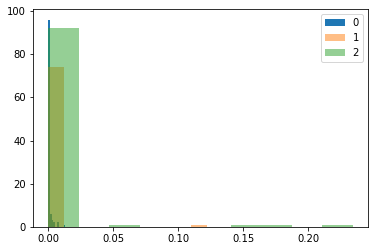

In [22]:
plt.hist(all_clipped[0], label='0')
plt.hist(all_clipped[1], alpha=.5, label='1')
plt.hist(all_clipped[2], alpha=0.5, label='2')
plt.legend()

None

In [26]:
np.max(all_clipped[2])

0.23411560519166918

#### mean-center data, sample cells from each group of interest (here: treatment) uniformly across batches

In [5]:
# scale and combine data
paths = ['../../new_outs/iNbatch01172024_CTP1b_Lipidspot_out//',
         '../../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/', 
         '../../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/']

o = []
x=0
for i in paths:
    out_parent = i
    df = pd.read_csv(out_parent+'quant_continuous.csv')
    
    df_sele = df[((df['treatment']=='vehicle') | (df['treatment']=='CDP-choline')) & (df['line']=='Y622')]

    # Find the minimum number of rows per 'line'
    min_rows_per_line = df_sele.groupby('treatment').size().min()

    # Sample uniformly without replacement
    sampled_df = df_sele.groupby('treatment').apply(lambda x: x.sample(n=min_rows_per_line, random_state=1)).reset_index(drop=True)

    sampled_df['scaled']  = (sampled_df['lipidspot'] - np.mean(sampled_df['lipidspot']))/np.std(sampled_df['lipidspot'])
    
    sampled_df['batch'] = str(x)
    
    o.append(sampled_df)
    x+=1

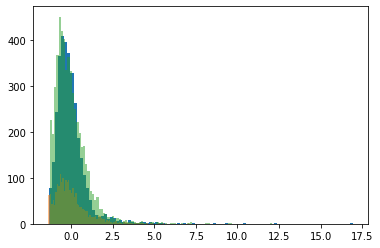

In [15]:
plt.hist(o[2]['scaled'], 100)
plt.hist(o[1]['scaled'], 100, alpha=.5)
plt.hist(o[0]['scaled'], 100, alpha=.5)

None


#### concatenate data across batches

In [6]:
# concat data

data = pd.concat(o)#[1:])

def split_string(s):
    if '-' in s:
        return s.split('-')[0]
    elif '_' in s:
        return s.split('_')[0]
    else:
        return s
    
data['well'] = [split_string(i) for i in data['file']]
data['well'] = data['batch'].str.cat(data['well'], sep=' ')

data.index = range(data.shape[0])

#### plot concatenated data across batches

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


vehicle vs. CDP-choline: t-test independent samples, P_val:9.152e-03 t=2.751e+00


<Figure size 180x360 with 0 Axes>

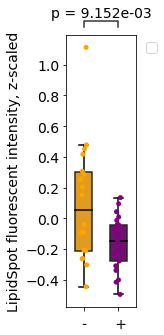

In [12]:
plt.figure(figsize=(2.5,5))


plt.figure(figsize=(1.25,5))
colors = dict(zip(np.unique(data['treatment']), [ 'purple', 'orange']))
colors2 = dict(zip(np.unique(data['treatment']), ['purple', 'orange']))

plot_boxplot_by_treatment('scaled', 'Y622', data, colors, colors2)
plt.rcParams.update({'font.size': 14})
plt.xticks(ticks=[0, 1], labels=['-','+'], rotation = 180)
plt.ylabel('LipidSpot fluorescent intensity, z-scaled')
plt.savefig('../../out_plots/lipidspot_new_cdp_choline.pdf')



#### plot per-cell distributions per batch

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


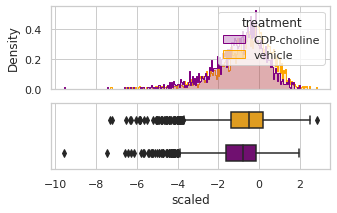

In [36]:
# plot combined

colors = dict(zip(['vehicle', 'CDP-choline'], ['orange', 'purple']))

plot_treatments(data, 'scaled', 'Y622', colors, True, 0.05, 1, t='CDP-choline', grp='well', size=(5,7))
#plt.xlim(-5,2.5)
#plt.savefig('../out_plots/mitohealth_treat_all.pdf')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


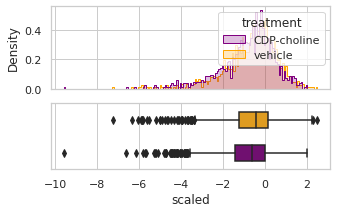

In [53]:
# plot combined

colors = dict(zip(['vehicle', 'CDP-choline'], ['orange', 'purple']))

plot_treatments(data[data['batch']=='0'], 'scaled', 'Y622', colors, True, 0.08, 1, t='CDP-choline', grp='well', size=(5,7))
plt.savefig('../out_plots/ls_treat_batch0.pdf')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


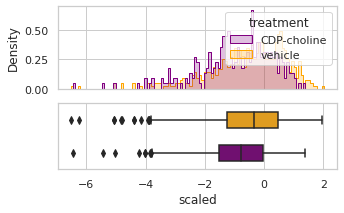

In [54]:
# plot combined

colors = dict(zip(['vehicle', 'CDP-choline'], ['orange', 'purple']))

plot_treatments(data[data['batch']=='1'], 'scaled', 'Y622', colors, True, 0.08, 1, t='CDP-choline', grp='well', size=(5,7))
plt.savefig('../out_plots/ls_treat_batch1.pdf')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


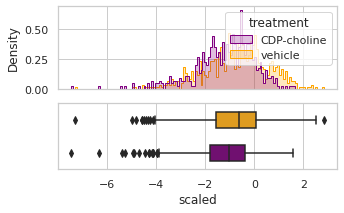

In [56]:
# plot combined

colors = dict(zip(['vehicle', 'CDP-choline'], ['orange', 'purple']))

plot_treatments(data[data['batch']=='2'], 'scaled', 'Y622', colors, True, 0.08, 1, t='CDP-choline', grp='well', size=(5,7))
#plt.xlim(-2,5)
plt.savefig('../out_plots/ls_treat_batch2.pdf')

#### Do stats

In [14]:
# do stats
from confocalQuant.stats import fit_mixed_model

print('E3 vs Y622 scaled across two batches:')
print(fit_mixed_model(data, "scaled ~ treatment", 'well'))


E3 vs Y622 scaled across two batches:
             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   scaled     
No. Observations:   10838     Method:               REML       
No. Groups:         39        Scale:                0.9212     
Min. group size:    102       Log-Likelihood:       -14997.5054
Max. group size:    531       Converged:            Yes        
Mean group size:    277.9                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.157    0.063 -2.477 0.013 -0.280 -0.033
treatment[T.vehicle]  0.255    0.093  2.751 0.006  0.073  0.437
Group Var             0.080    0.020                           



In [29]:
# do stats
from confocalQuant.stats import fit_mixed_model

print('E3 vs Y622 scaled across two batches:')
print(fit_mixed_model(data[data['batch']=='1'], "scaled ~ treatment", 'well'))


E3 vs Y622 scaled across two batches:
             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   scaled    
No. Observations:    2040      Method:               REML      
No. Groups:          11        Scale:                0.8890    
Min. group size:     102       Log-Likelihood:       -2789.8699
Max. group size:     318       Converged:            Yes       
Mean group size:     185.5                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.284    0.094 -3.014 0.003 -0.469 -0.099
treatment[T.vehicle]  0.483    0.155  3.123 0.002  0.180  0.786
Group Var             0.056    0.031                           



In [30]:
# do stats
from confocalQuant.stats import fit_mixed_model

print('E3 vs Y622 scaled across two batches:')
print(fit_mixed_model(data[data['batch']=='2'], "scaled ~ treatment", 'well'))


E3 vs Y622 scaled across two batches:
             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   scaled    
No. Observations:    3362      Method:               REML      
No. Groups:          12        Scale:                0.8965    
Min. group size:     172       Log-Likelihood:       -4609.8109
Max. group size:     457       Converged:            Yes       
Mean group size:     280.2                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.139    0.148 -0.938 0.348 -0.430  0.152
treatment[T.vehicle]  0.315    0.210  1.501 0.133 -0.096  0.726
Group Var             0.129    0.063                           



In [31]:
# do stats
from confocalQuant.stats import fit_mixed_model

print('E3 vs Y622 scaled across two batches:')
print(fit_mixed_model(data[data['batch']=='1'], "scaled ~ treatment", 'well'))


E3 vs Y622 scaled across two batches:
             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   scaled    
No. Observations:    2040      Method:               REML      
No. Groups:          11        Scale:                0.8890    
Min. group size:     102       Log-Likelihood:       -2789.8699
Max. group size:     318       Converged:            Yes       
Mean group size:     185.5                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.284    0.094 -3.014 0.003 -0.469 -0.099
treatment[T.vehicle]  0.483    0.155  3.123 0.002  0.180  0.786
Group Var             0.056    0.031                           

